In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np

import pymc as pm
import pymc_bart as pb

import arviz as az
import matplotlib.pyplot as pp
from matplotlib.axes._axes import Axes
from matplotlib.figure import Figure

Some usefull functions

In [ ]:
def plot_bayesian_regression_posterior_predictive(
        x_data: np.array, idata: az.InferenceData, ax: pp.Axes, 
        hdi_prob: float=0.94):
    """
    Plots the Highest Density Interval (HDI) of the overall posterior
    predictive distribution for a regression model.

    Args:
        df (pd.DataFrame): DataFrame containing the original data with 'log_MBR'.
                           Used to determine the x-range for plotting.
        idata (arviz.InferenceData): InferenceData object containing the
                                          posterior_predictive samples.
                                          Assumes the predicted variable is
                                          named 'likelihood' and has no group dimension.
        ax (matplotlib.axes.Axes): The axes object to plot on.
    """

    # Select the entire posterior predictive samples for 'likelihood'.
    # Assumes no group dimension exists here.
    try:
        ppd_likelihood = idata.posterior_predictive['likelihood']
    except KeyError:
        print("Error: 'likelihood' not found in idata.posterior_predictive.")
        return
    except Exception as e:
        print(f"An error occurred selecting posterior predictive: {e}")
        return


    # Plot the Highest Density Interval (HDI) of the overall posterior predictive distribution.
    # This visualizes the expected range for new observations across all groups,
    # accounting for both uncertainty in the mean and the residual variance.
    # We'll use a distinct color or style for this overall HDI.
    az.plot_hdi(
        x_data,
        ppd_likelihood,
        ax=ax,
        color='black',
        hdi_prob=hdi_prob,
        fill_kwargs={'alpha': 0.30}
    )


def plot_regression_hdi(
    idata:az.InferenceData, X:pd.Series, y:pd.Series, hdi_prob=0.94) -> tuple[Figure, Axes]:   
    """
    Generates a posterior predictive regression plot with observed data.

    Parameters
    ----------
    idata : arviz.InferenceData
        An ArviZ InferenceData object containing the posterior predictive samples.
    X : pandas.Series
        The independent variable (e.g., log(MBR)) used in the regression.
    y : pandas.Series
        The observed dependent variable (e.g., log(Chl a)).

    Returns
    -------
    matplotlib.figure.Figure
        The generated Matplotlib Figure object.
    matplotlib.axes.Axes
        The generated Matplotlib Axes object.

    Notes
    -----
    This function assumes that `plot_bayesian_regression_posterior_predictive`
    is defined and available in the current scope. It overlays the observed
    data points on top of the posterior predictive plot.
    """
    fig, ax = pp.subplots(figsize=(10, 6)) # Create figure and axes
    plot_bayesian_regression_posterior_predictive(X, idata, ax=ax, hdi_prob=hdi_prob)
    ax.scatter(X, y, zorder=1, color='orange', edgecolors='k', alpha=0.5)
    ax.set_title('Posterior Predictive Regression Plot')
    ax.set_xlabel('log(MBR)')
    ax.set_ylabel('log(Chl a)')
    return fig, ax


## Methods

### Model Definitions

In [ ]:
# Create coordinates for modeling with PyMC
# assign features and target to

mbr_type_idx, mbr_type = df_training.MBR_flag.factorize(sort=True)
chl_type_idx, chl_type = df_training.hplc_flag.factorize(sort=True)
COORDS = {
    'MBR_numerator': mbr_type,
    'chl_type': chl_type,
    'obs_idx': df_training.index
}

X = df_training.log_MBR
y = df_training.log_chl

----


### Model 5 - Hierarchical Partial Pooling Linear Model with Hierarchical Linear Heteroscedasticity

In [ ]:
with pm.Model(coords=COORDS) as model_5:
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data('group_idx', mbr_type_idx, dims='obs_idx')
    X_data = pm.Data('X', X.values, dims='obs_idx')
    # ------- Hyper-priors ---------
    # μ (mean) term
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)
    # σ (dispersion parameter) term
    σ_α_μ = pm.Normal('σ_α_μ', 0, 1)
    σ_α_σ = pm.Exponential('σ_α_σ', 1)
    σ_β_μ = pm.Normal('σ_β_μ', 0, 1)
    σ_β_σ = pm.Exponential('σ_β_σ', 1)
    
    # ------- Priors -----------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    σ_α = pm.Normal('σ_α', σ_α_μ, σ_α_σ, dims='MBR_numerator')
    σ_β = pm.Normal('σ_β', σ_β_μ, σ_β_σ, dims='MBR_numerator')
    
    # ------ Likelihood --------------
    #σ_ = pm.Gamma('σ_', σ_γ, σ_φ, dims='MBR_numerator')
    μ = α[group_idx] + β[group_idx] * X_data
    log_σ = σ_α[group_idx] + σ_β[group_idx] * X_data
    σ = pm.Deterministic('σ', pm.math.exp(log_σ))
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, observed=y, dims='obs_idx')

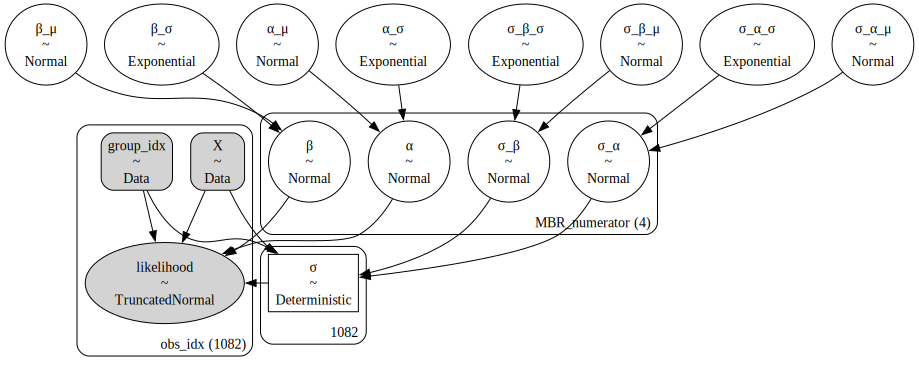

In [ ]:
model_5.to_graphviz()

In [ ]:
g5 = model_5.to_graphviz()
#g5.render(filename='model5_structure', directory=img_path, format='png')

'/Users/erdemkarakoylu/projex/bayesian_chl/manuscript/images/model5_structure.png'

#### Model 5 Prior Preddictive Sampling

In [ ]:
with model_5:
    idata_5 = pm.sample_prior_predictive()

Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, σ_α, σ_α_μ, σ_α_σ, σ_β, σ_β_μ, σ_β_σ]


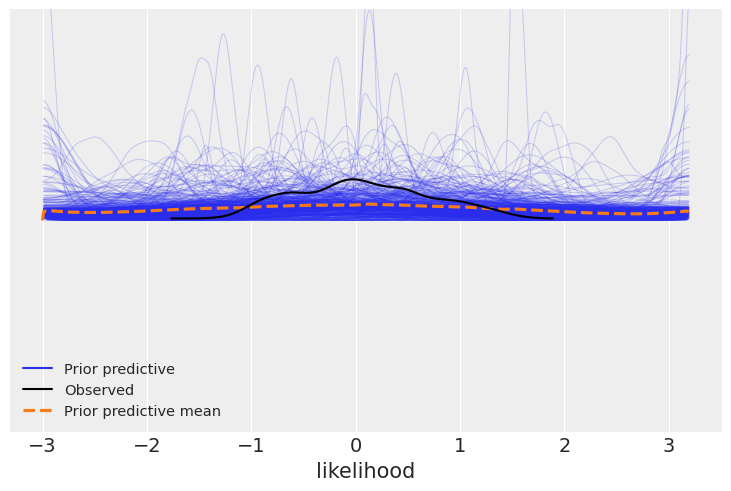

In [ ]:
f, ax = pp.subplots()
az.plot_ppc(idata_5, group='prior', observed=True, ax=ax)
ax.set_ylim(-3, 3)
#f.savefig(img_path/'model5_prior_pc.png', dpi=300)

#### Model 5 Sampling

In [ ]:
with model_5:
    idata_5.extend(pm.sample(draws=2000, chains=4, target_accept=0.95))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, σ_α_μ, σ_α_σ, σ_β_μ, σ_β_σ, α, β, σ_α, σ_β]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


Posterior Predictive Check

In [ ]:
with model_5:
    idata_5.extend(pm.sample_posterior_predictive(idata_5))

Sampling: [likelihood]


Output()

## Results 
### Model 5
#### Posterior Distribution of Select Parameters

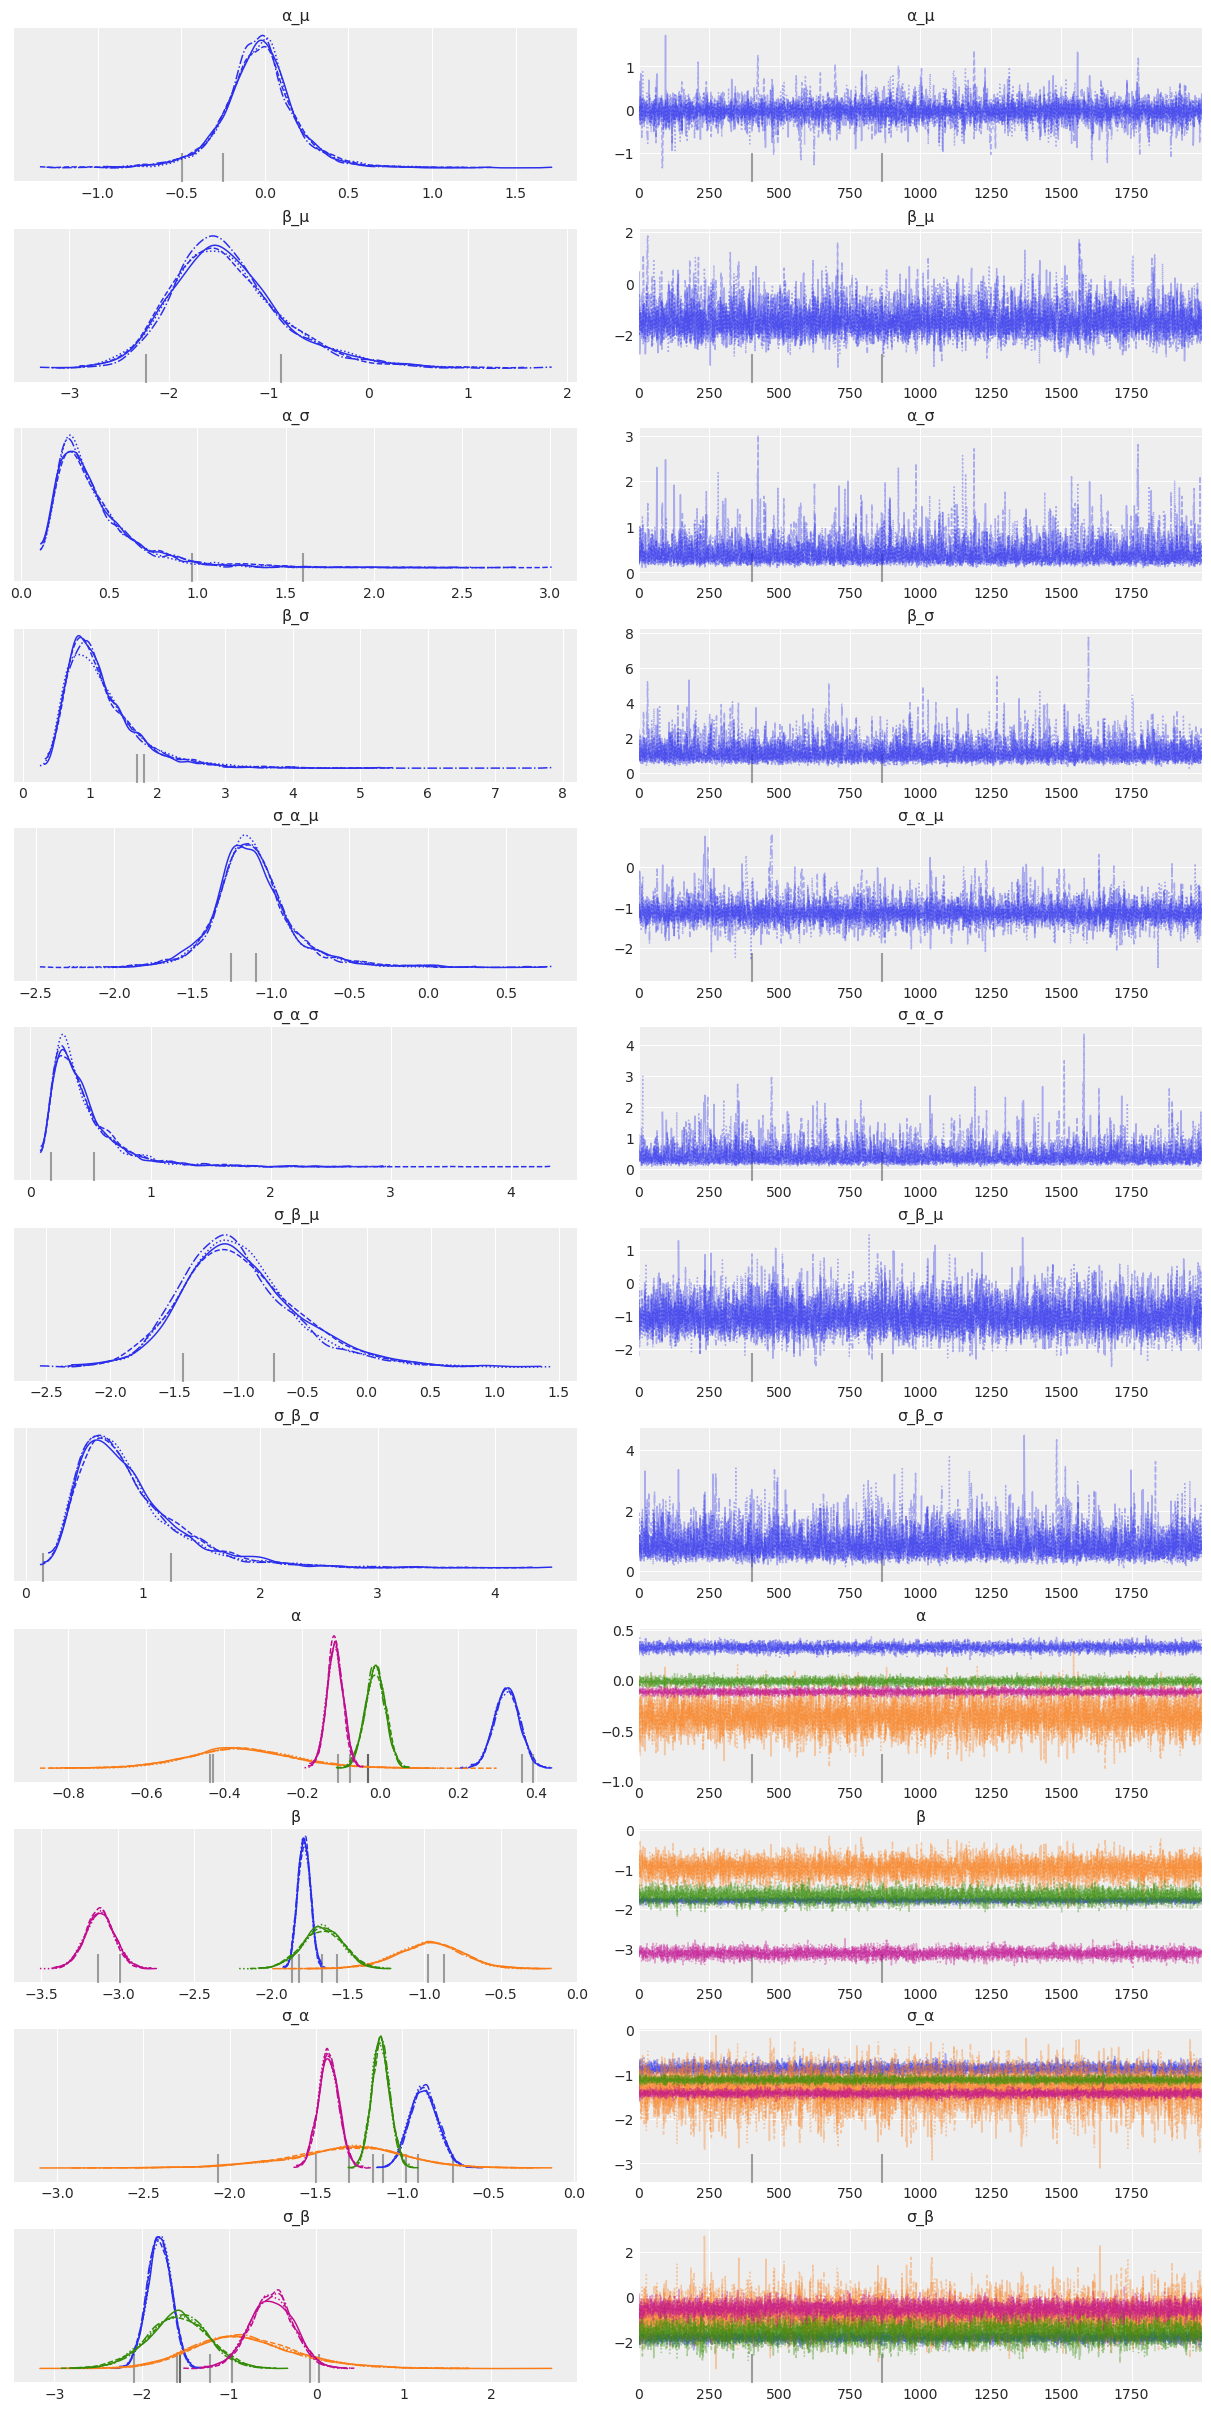

In [ ]:
axs= az.plot_trace(
    idata_5, 
    var_names=[
        'α_μ', 'β_μ', 'α_σ', 'β_σ', 'σ_α_μ', 'σ_α_σ', 'σ_β_μ', 'σ_β_σ', # hyperpriors
        'α', 'β', 'σ_α', 'σ_β'] # priors
        )
f = pp.gcf()
#f.savefig(img_path / 'model5_trace_plot.png', dpi=300)

#### Posterior Predictive Checks Result

/var/folders/c9/p_x94m2j357984db558g2n9m0000gn/T/ipykernel_29556/2704516647.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fppc_5.savefig(img_path / 'model5_post_pc.png', dpi=300)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/erdemkarakoylu/miniconda3/envs/pymc_base/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


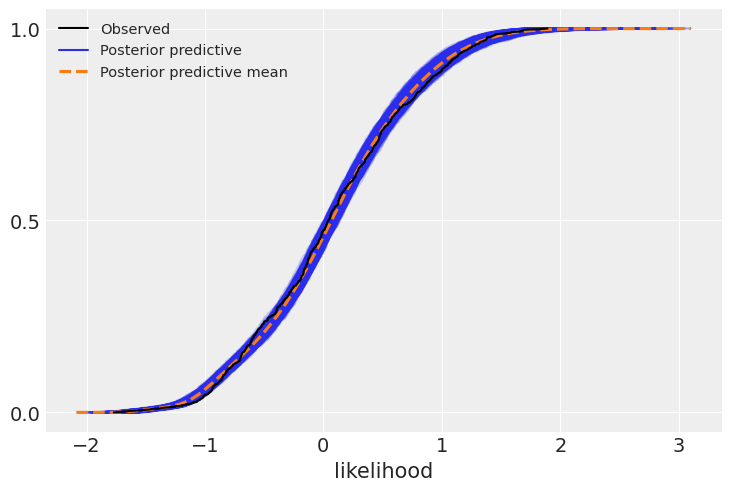

In [ ]:
fppc_5, ax = pp.subplots()
az.plot_ppc(idata_5, ax=ax, kind='cumulative')
#fppc_5.savefig(img_path / 'model5_post_pc.png', dpi=300)

#### Model Prediction Uncertainty 

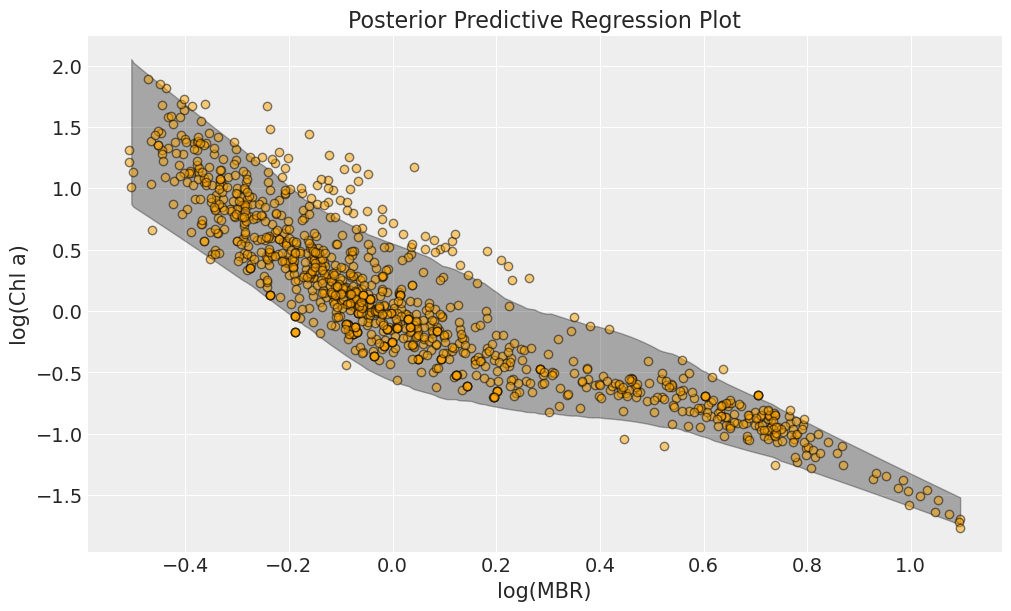

In [ ]:
fig, ax = plot_regression_hdi(idata_5, X=X, y=y, hdi_prob=0.94)
#fig.savefig(img_path/'model5_hdi_plot.png', dpi=300)

### Model 6 Beyond Heteroscedasticity: 
### Fluorescence- vs HPLC-Based Uncertainty

In this section, we address potential differences in observation noise between chlorophyll measurements obtained via fluorescence and those obtained via HPLC.

Fluorescence-based measurements are generally considered less precise, with variability that scales with the signal itself. To capture this behavior, we introduce an additive offset term to the logarithm of the observation noise standard deviation. Modeling noise in log-space not only ensures positivity but also accommodates multiplicative error structures, common in fluorescence-based observations.

To implement this, we extend the hierarchical linear formulation of $\log \sigma$ used previously by incorporating an additive term $\gamma$, which is activated only for fluorescence-derived observations. The binary chl_type flag used during exploratory data analysis is set to 0 for fluorescence and 1 for HPLC, so the term $\gamma (1 - chl\_type)$ increases the predicted noise for fluorescence while leaving HPLC observations unaffected. This formulation allows us to directly assess the contribution of measurement method to overall uncertainty:
$$ \log \sigma^{(i)} = \sigma_{\alpha}^{(i)} + \sigma_{\beta}^{(i)} X +\gamma (1-chl\_type)\tag{10}$$


#### Model 6 - Definition

In [ ]:
with pm.Model(coords=COORDS) as model_6:
    # Register group index and predictor with obs dimensions
    group_idx = pm.Data('group_idx', mbr_type_idx, dims='obs_idx')
    X_data = pm.Data('X', X.values, dims='obs_idx')
    chl_type_idx_shared = pm.Data("chl_type_idx", chl_type_idx, dims="obs_idx")

    # ------- Hyper-priors ---------
    # μ (mean) term
    α_μ = pm.Normal('α_μ', 0, 1)
    α_σ = pm.Exponential('α_σ', 1)
    β_μ = pm.Normal('β_μ', 0, 1)
    β_σ = pm.Exponential('β_σ', 1)
    # σ (dispersion parameter) term
    σ_α_μ = pm.Normal('σ_α_μ', 0, 1)
    σ_α_σ = pm.Exponential('σ_α_σ', 1)
    σ_β_μ = pm.Normal('σ_β_μ', 0, 1)
    σ_β_σ = pm.Exponential('σ_β_σ', 1)
    
    # ------- Priors -----------------
    α = pm.Normal('α', α_μ, α_σ, dims='MBR_numerator')
    β = pm.Normal('β', β_μ, β_σ, dims='MBR_numerator')
    σ_α = pm.Normal('σ_α', σ_α_μ, σ_α_σ, dims='MBR_numerator')
    σ_β = pm.Normal('σ_β', σ_β_μ, σ_β_σ, dims='MBR_numerator')
    γ_chl_type = pm.Normal("γ_chl_type", mu=0, sigma=1) # fluorescence measurement noise contribution



    # ------ Likelihood --------------
    #σ_ = pm.Gamma('σ_', σ_γ, σ_φ, dims='MBR_numerator')
    μ = α[group_idx] + β[group_idx] * X_data
    log_σ = (
        σ_α[group_idx]
        + σ_β[group_idx] * X_data
        + γ_chl_type * (1 - chl_type_idx_shared)
        )
    σ = pm.Deterministic("σ", pm.math.exp(log_σ))
    #log_σ = σ_α[group_idx] + σ_β[group_idx] * X_data + \gamma
    #σ = pm.Deterministic('σ', pm.math.exp(log_σ))
    likelihood = pm.TruncatedNormal(
        'likelihood', mu=μ, sigma=σ, lower=-3, upper=3.2, observed=y, dims='obs_idx')

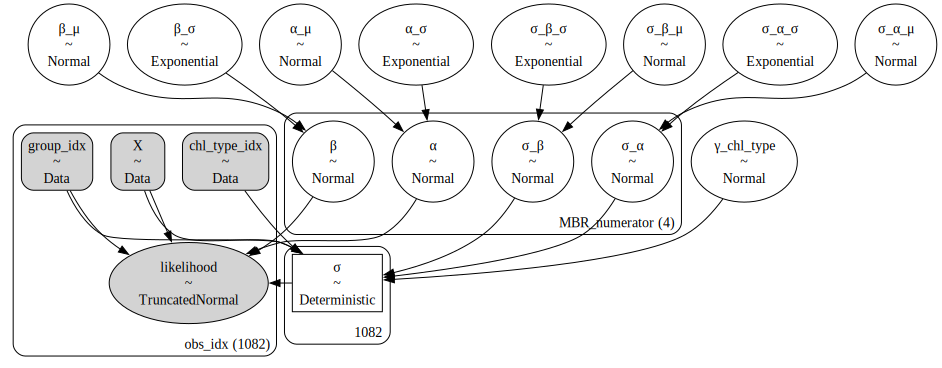

In [ ]:
model_6.to_graphviz()

In [ ]:
g6 = model_6.to_graphviz()
g6.render(filename='model6_structure', directory=img_path, format='png')

'/Users/erdemkarakoylu/projex/bayesian_chl/manuscript/images/model6_structure.png'

#### Model 6 - Prior Predictive Sampling

In [ ]:
with model_6:
    idata_6 = pm.sample_prior_predictive()

Sampling: [likelihood, α, α_μ, α_σ, β, β_μ, β_σ, γ_chl_type, σ_α, σ_α_μ, σ_α_σ, σ_β, σ_β_μ, σ_β_σ]


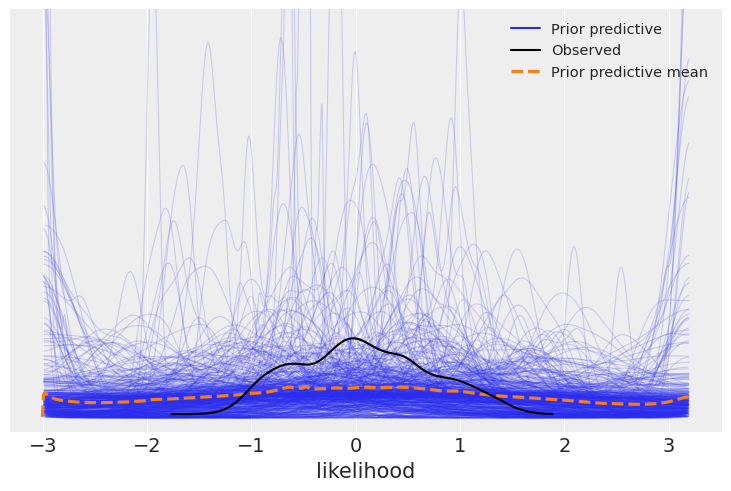

In [ ]:
fprior_6, ax = pp.subplots()
az.plot_ppc(idata_6, group='prior', observed=True, ax=ax)
ax.set_ylim(-0.1, 3)
#fprior6.savefig(img_path / 'model6_prior_pc.png', dpi=300)

#### Model 6 - Sampling

In [ ]:
with model6:
    idata6.extend(pm.sample(draws=2000, chains=4, target_accept=0.95))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ, α_σ, β_μ, β_σ, σ_α_μ, σ_α_σ, σ_β_μ, σ_β_σ, α, β, σ_α, σ_β, γ_chl_type]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


#### Model 6 - Posterior Predictive Sampling

In [ ]:
with hl_mbr_hl_het_fluo_noise:
    idata_hlmbr_hl_het_fn.extend(
        pm.sample_posterior_predictive(idata_hlmbr_hl_het_fn))

Sampling: [likelihood]


Output()

## Model 6 Results
### Model 6 - Posterior Distribution of Select Parameters

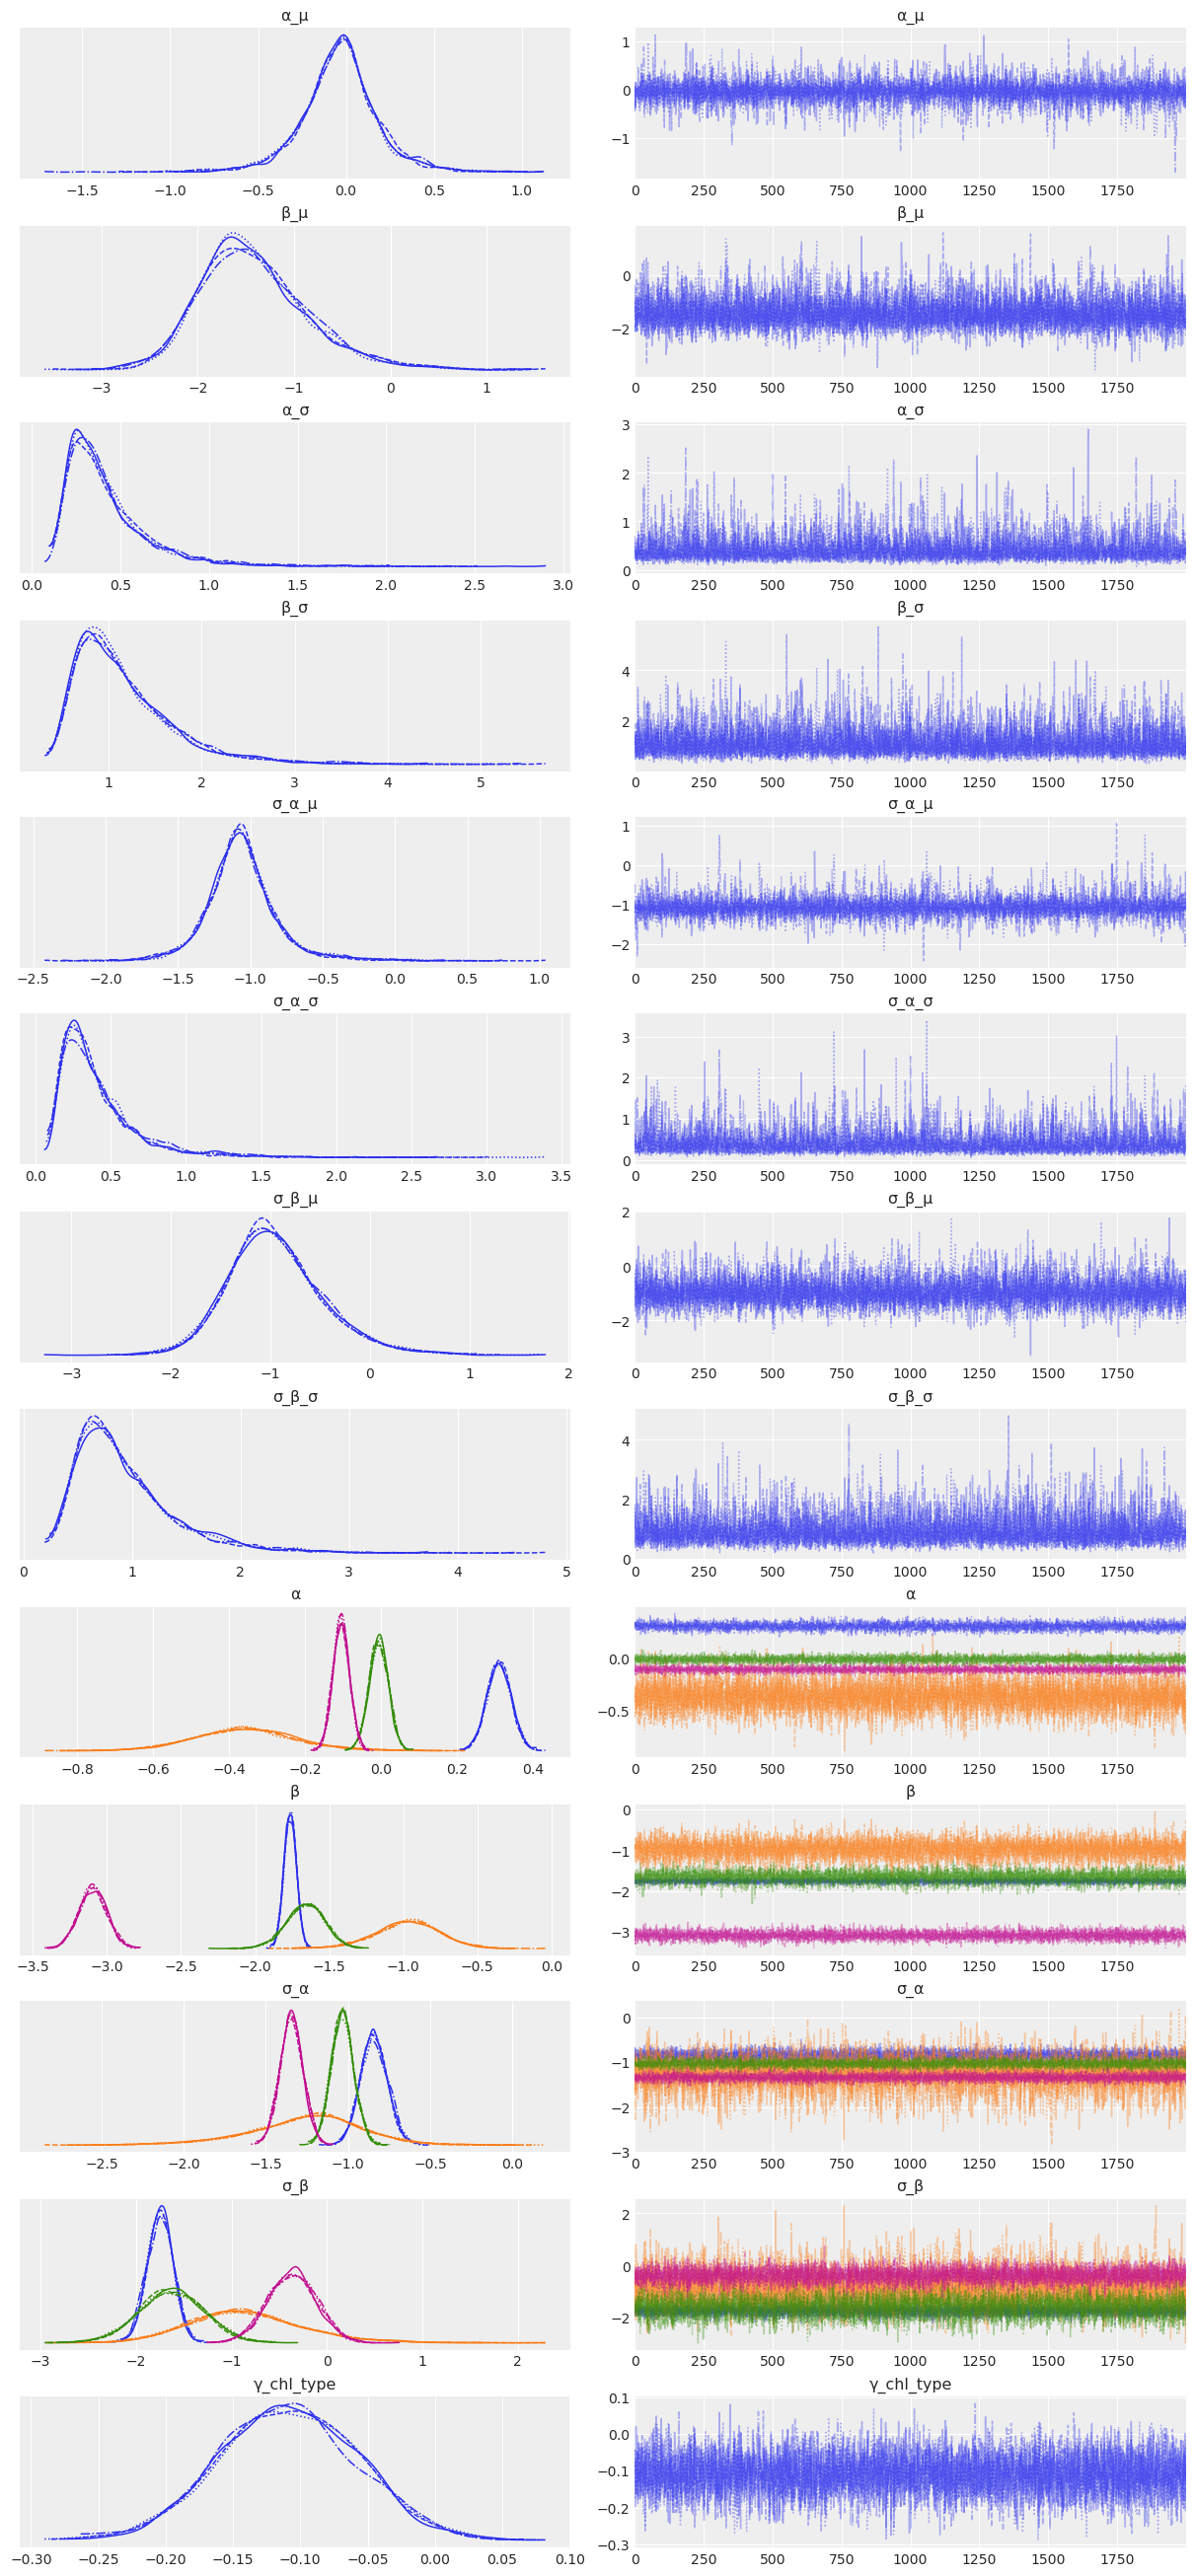

In [ ]:
axes = az.plot_trace(
    idata6,
    var_names=[
        'α_μ', 'β_μ', 'α_σ', 'β_σ', 'σ_α_μ', 'σ_α_σ', 'σ_β_μ', 'σ_β_σ', # hyperpriors
        'α', 'β', 'σ_α', 'σ_β', 'γ_chl_type'] # priors
        )
f = pp.gcf()
#f.savefig(img_path / 'model_6_trace_plot.png', dpi=300)

array([[<Axes: title={'center': 'σ_α\nRrs411'}>,
        <Axes: title={'center': 'σ_α\nRrs443'}>],
       [<Axes: title={'center': 'σ_α\nRrs489'}>,
        <Axes: title={'center': 'σ_α\nRrs510'}>]], dtype=object)

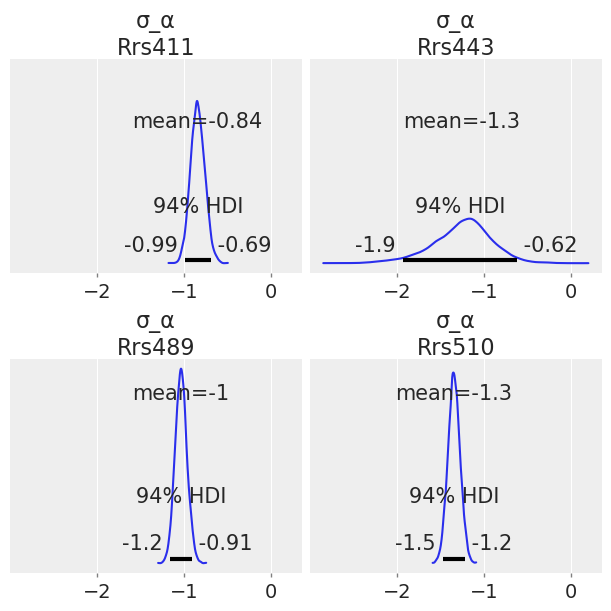

In [ ]:
f, axs = pp.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6))
az.plot_posterior(
    idata_hlmbr_hl_het_fn, var_names='σ_α', ax=axs
    )
f.suptitle('Group-Specific  σ_α');

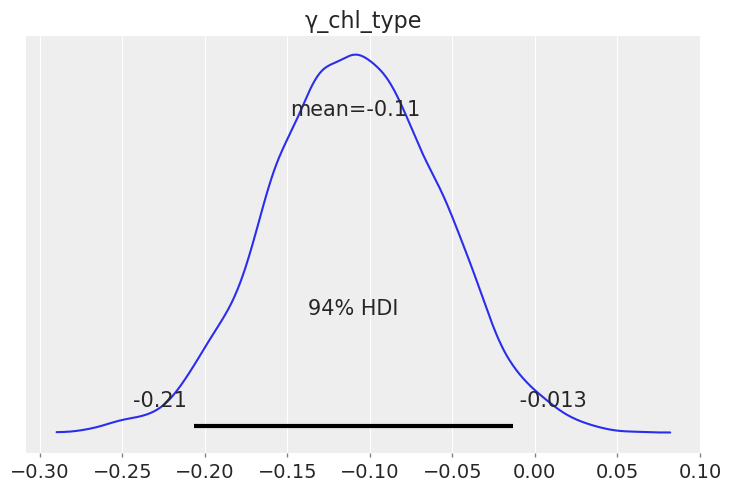

In [ ]:
f, ax = pp.subplots()
az.plot_posterior(idata_hlmbr_hl_het_fn, var_names='γ_chl_type', ax=ax)
f.savefig(img_path / 'model_6_chl_type_posterior.png', dpi=300)

### Model 6 - Posterior Predictive Checks 

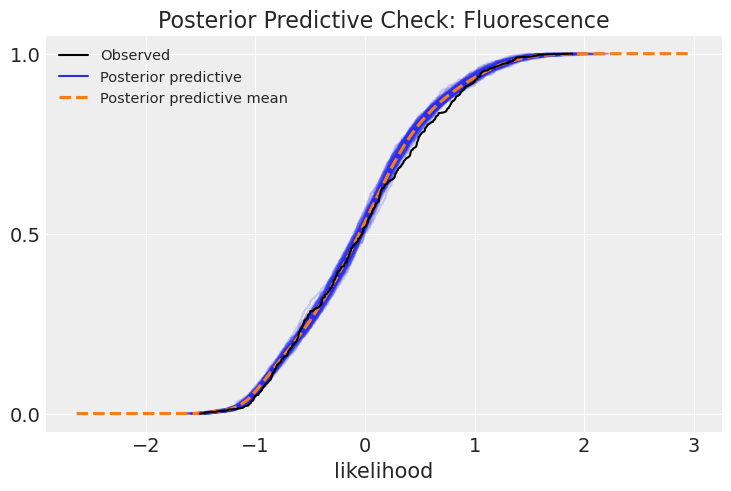

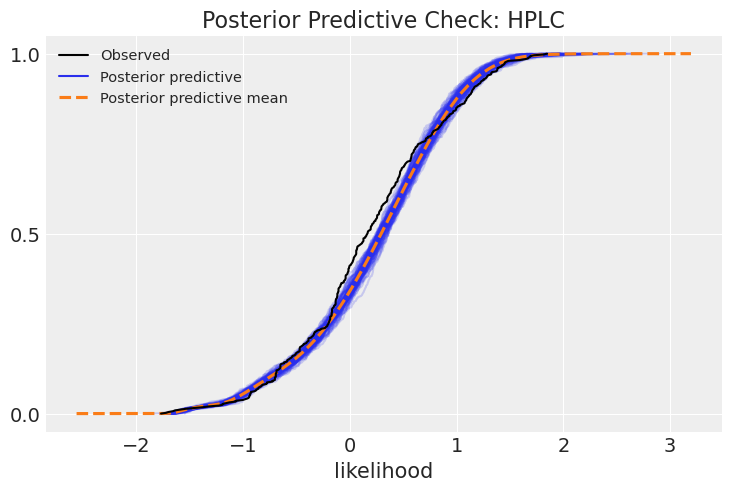

In [ ]:
f_fluo, ax_fluo = pp.subplots()
f_hplc, ax_hplc = pp.subplots()
is_fluo = df_training["hplc_flag"] == 'fluo'
is_hplc = df_training["hplc_flag"] == 'hplc'
obs_fluo = df_training.index[is_fluo]
obs_hplc = df_training.index[is_hplc]
idata_fluo = idata_hlmbr_hl_het_fn.sel(obs_idx=obs_fluo)
idata_hplc = idata_hlmbr_hl_het_fn.sel(obs_idx=obs_hplc)

az.plot_ppc(idata_fluo, var_names=["likelihood"], num_pp_samples=100, jitter=0.05, ax=ax_fluo, kind='cumulative')
ax_fluo.set_title("Posterior Predictive Check: Fluorescence")

az.plot_ppc(idata_hplc, var_names=["likelihood"], num_pp_samples=100, jitter=0.05, ax=ax_hplc, kind='cumulative')
ax_hplc.set_title("Posterior Predictive Check: HPLC")
f_fluo.savefig(img_path/'model7_posterior_pc_fluo.png', dpi=300)
f_hplc.savefig(img_path/'model7_posterior_pc_hplc.png', dpi=300)

Contrary to prior assumptions, the posterior distribution for the fluorescence-specific noise offset ($\gamma_{\text{chl}}$) was concentrated below zero, with a 94% HDI of [−0.21, 0.012], suggesting that fluorescence-derived chlorophyll measurements were slightly less noisy than HPLC-derived observations in this dataset. This finding runs contrary to the prior expectation that fluorescence measurements are noisier. However it is not a modeling artifact — it's a real signal in the data implying that 
* Either HPLC noise is greater than assumed (e.g., due to lab variation, batch effects),
* Or fluorescence is surprisingly consistent in the training dataset, possibly due to standardized protocols or strong preprocessing.
The data does not allow us to speculate further but this should be investigated further.

### Model 6 - Prediction Uncertainty

### Model 6 - Posterior Predictive Residuals by Measurement Type (suggested for results section)
To evaluate the model’s performance across measurement types, we conducted posterior predictive checks stratified by whether chlorophyll observations were derived from fluorescence or HPLC. The model closely captured the distribution of fluorescence-based observations, with residuals tightly centered around zero. In contrast, residuals for HPLC-based observations were more dispersed, particularly in the low-chlorophyll regime (log₁₀(Chl) < 0). Fluorescence measurements exhibited greater posterior predictive density near zero residuals, suggesting a tighter model fit and lower predictive uncertainty. This pattern challenges the prior expectation that fluorescence-derived observations would be noisier, and instead points to greater variability or systematic effects in HPLC observations at low concentrations.


### Interpreting Measurement-Type-Dependent Uncertainty (suggested for discussion section)
Contrary to the initial hypothesis that fluorescence-derived chlorophyll measurements would exhibit greater noise, posterior predictive checks revealed that model residuals were more dispersed for HPLC-based observations, particularly in low-chlorophyll waters. This finding may reflect heterogeneity in HPLC measurement procedures, including variability in extraction protocols, instrumentation, or inter-laboratory calibration. The observed asymmetry in residual structure motivated the introduction of a measurement-type-specific interaction term in the log-noise model, allowing uncertainty to vary with both method and signal magnitude. Future work could further disentangle these effects by conditioning on known sources of variability such as laboratory identity, sampling equipment, analyst, or region. Expanding metadata collection to include these factors and incorporating them as hierarchical levels in the model could clarify whether residual dispersion is due to methodological differences or environmental sampling context.

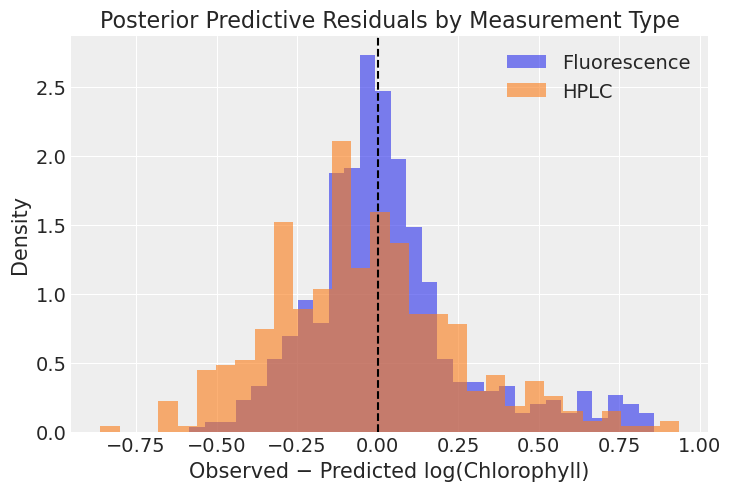

In [ ]:
# Convert posterior predictive mean to NumPy array
y_pp_mean = idata_6.posterior_predictive["likelihood"].mean(dim=["chain", "draw"]).values

# Observed values as NumPy array
y_obs = df_training["log_chl"].values

# Residuals
residuals = y_obs - y_pp_mean

# Ensure masks are NumPy arrays (drop index alignment)
is_fluo_np = df_training["hplc_flag"].values == 'fluo'
is_hplc_np = df_training["hplc_flag"].values == 'hplc'

# Plot histograms
f, ax = pp.subplots()
ax.hist(residuals[is_fluo_np], bins=30, alpha=0.6, label="Fluorescence", density=True)
ax.hist(residuals[is_hplc_np], bins=30, alpha=0.6, label="HPLC", density=True)
ax.axvline(0, color="black", linestyle="--")
ax.legend()
ax.set_title("Posterior Predictive Residuals by Measurement Type")
ax.set_xlabel("Observed − Predicted log(Chlorophyll)")
ax.set_ylabel("Density")

f.savefig(img_path / 'model7_ppc_residuals.png', dpi=300)